In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install "numpy<2 "
!pip install torch
!pip install scanpy
!pip install pyensembl
!pip install tqdm
!pip install matplotlib
!pip install causal-conv1d
!pip install mamba-ssm
!pip install scikit-learn

In [3]:
from torch.utils.data import random_split, DataLoader, Dataset
from IPython.display import clear_output, display
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import scanpy as sc
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pyensembl
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [4]:
import drive.MyDrive.Projects.MambaPerturb.virtual_cell.src.modelnew as m
import drive.MyDrive.Projects.MambaPerturb.virtual_cell.src.data_cleaning as dc
import drive.MyDrive.Projects.MambaPerturb.virtual_cell.src.position_encoding as pos
import drive.MyDrive.Projects.MambaPerturb.virtual_cell.src.pathway_encoding as path
import drive.MyDrive.Projects.MambaPerturb.virtual_cell.src.trainingnew as trainN

In [5]:
ensembl_data = pyensembl.EnsemblRelease(109)
ensembl_data.download()
ensembl_data.index()

adata = sc.read_h5ad('drive/MyDrive/Projects/MambaPerturb/virtual_cell/vcc_data/adata_Training.h5ad')
#adata.obs['perturbation_idx'] = np.random.randint(0, CONFIG["n_perturbations"], size=adata.n_obs)
gene_names = pd.read_csv('drive/MyDrive/Projects/MambaPerturb/virtual_cell/vcc_data/gene_names.csv', header = None)
gene_names = gene_names.iloc[:, 0].tolist()


CONFIG = {
    "n_genes": len(gene_names), #total number of expression genes needed to predict
    "n_perturbations": len(adata.obs['target_gene'].unique().tolist()), #number of unique perturbations
    "n_chromosomes": 25, #chromosome number 23+X+Y

    "perturbation_dim": 256,      # Condition embedding
    "chrom_embedding_dim": 16,     # Learned in-model for chromosome identity
    "locus_fourier_features": 8,   # Number of Fourier frequency pairs (2*F)
    "pathway_dim": 50,             # From pre-trained Autoencoder(based on hallmark MSigDB)
    "gene_identity_dim": 189,       # Main learnable gene embedding

    # Backbone dims
    "d_model": 512,                # Mamba hidden size
    "mamba_layers": 4,
    "n_heads": 8,
    "n_layers": 4,

    # Head
    "prediction_head": "probabilistic", # "linear" | "probabilistic"

    # Training
    "batch_size": 16,
    "learning_rate": 5e-5, # Lowered LR for AdamW stability
    "epochs": 100,
}

# Derived dimensions for clarity
# Positional encoding dim = chromosome embedding + MLP output from Fourier features
POS_DIM = CONFIG["chrom_embedding_dim"] + CONFIG["chrom_embedding_dim"]
GENE_FEAT_DIM = CONFIG["gene_identity_dim"] + CONFIG["pathway_dim"] + POS_DIM

In [6]:

unique_perturbations = adata.obs['target_gene'].unique().tolist()
perturbation_to_idx_map = {name: i for i, name in enumerate(unique_perturbations)}
adata.obs['perturbation_idx'] = adata.obs['target_gene'].map(perturbation_to_idx_map)
control_adata = dc.get_control_data(adata)
chr_idx, locus_norm, locus_fourier = pos.precompute_positional_indices(ensembl_data, gene_names, CONFIG)




--- Preparing positional indices using pyensembl ---


Fetching gene positions: 100%|██████████| 18080/18080 [00:01<00:00, 16963.23it/s]


SUCCESS: Generated positional tensors with shapes:
Chromosome Indices (chr_idx): torch.Size([18080])
Normalized Locus (locus_norm): torch.Size([18080, 1])
Locus Fourier Features (locus_fourier): torch.Size([18080, 16])


In [7]:
pathway_feats = path.precompute_pathway_features(control_adata, CONFIG)

--- Precomputing pathway features on control data ---
Generated pathway_features shape: torch.Size([18080, 50])


In [8]:
device = torch.device("cuda")
print(f"\nUsing device: {device}")
model = m.TranscriptomePredictor(CONFIG, GENE_FEAT_DIM, pathway_feats, chr_idx, locus_fourier)
model.to(device)

dataset = m.PerturbationDataset(adata, CONFIG) # Pass CONFIG to the dataset constructor
train_loader = DataLoader(dataset, batch_size=CONFIG["batch_size"], shuffle=True)


Using device: cuda
Dataset using log-normalized data from adata.X for linear head.


In [9]:
'''device = torch.device("cuda")
print(f"\nUsing device: {device}")
model = m.TranscriptomePredictor(CONFIG, GENE_FEAT_DIM, pathway_feats, chr_idx, locus_fourier)
model.to(device)
# --- Do this right after you load your full 'adata' ---

# Get a list of indices (0, 1, 2, ... n_obs)
indices = adata.obs.index

# Split the indices into 80% train, 20% validation
train_idx, valid_idx = train_test_split(indices, test_size=0.2, random_state=42)

# Create the two separate AnnData objects
train_adata = adata[train_idx, :].copy()
valid_adata = adata[valid_idx, :].copy()

print(f"Full dataset: {adata.n_obs} samples")
print(f"Training set:   {train_adata.n_obs} samples")
print(f"Validation set: {valid_adata.n_obs} samples")

# --- NOW, create your Datasets and DataLoaders from these ---
train_dataset = m.PerturbationDataset(train_adata, CONFIG)
valid_dataset = m.PerturbationDataset(valid_adata, CONFIG)

train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=CONFIG["batch_size"], shuffle=False)'''

'device = torch.device("cuda")\nprint(f"\nUsing device: {device}")\nmodel = m.TranscriptomePredictor(CONFIG, GENE_FEAT_DIM, pathway_feats, chr_idx, locus_fourier)\nmodel.to(device)\n# --- Do this right after you load your full \'adata\' ---\n\n# Get a list of indices (0, 1, 2, ... n_obs)\nindices = adata.obs.index\n\n# Split the indices into 80% train, 20% validation\ntrain_idx, valid_idx = train_test_split(indices, test_size=0.2, random_state=42)\n\n# Create the two separate AnnData objects\ntrain_adata = adata[train_idx, :].copy()\nvalid_adata = adata[valid_idx, :].copy()\n\nprint(f"Full dataset: {adata.n_obs} samples")\nprint(f"Training set:   {train_adata.n_obs} samples")\nprint(f"Validation set: {valid_adata.n_obs} samples")\n\n# --- NOW, create your Datasets and DataLoaders from these ---\ntrain_dataset = m.PerturbationDataset(train_adata, CONFIG)\nvalid_dataset = m.PerturbationDataset(valid_adata, CONFIG)\n\ntrain_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"

In [10]:
print("--- RUNNING DATA PURITY CHECK (Corrected) ---")

# 1. Check the TARGET data (adata.X) - This is NumPy
print("Checking adata.X (for targets)...")
X_data = adata.X.toarray() if hasattr(adata.X, "toarray") else np.asarray(adata.X)

if np.isnan(X_data).any():
    print("!!!!! NaN DETECTED IN ADATA.X !!!!!")
    print("This is your problem. Your target labels are NaN.")
    print("Fixing by replacing NaNs with 0...")
    adata.X = np.nan_to_num(X_data, nan=0.0)
    print("adata.X has been cleaned.")
else:
    print("OK: adata.X is clean.")


# 2. Check the INPUT FEATURE data (pathway_feats) - This is NumPy
print("\nChecking pathway_feats...")
# --- FIX IS HERE: Use np.isnan for numpy arrays ---
if np.isnan(pathway_feats).any() or np.isinf(pathway_feats).any():
    print("!!!!! NaN/Inf DETECTED IN PATHWAY_FEATS !!!!!")
    print("This is your problem. Your pathway features are poisoned.")
    print("Fixing by replacing NaNs/Infs with 0...")
    # --- FIX IS HERE: Use np.nan_to_num ---
    pathway_feats = np.nan_to_num(pathway_feats, nan=0.0, posinf=0.0, neginf=0.0)
    print("pathway_feats has been cleaned.")
else:
    print("OK: pathway_feats is clean.")


# 3. Check the INPUT FEATURE data (locus_fourier) - This is a Torch Tensor
print("\nChecking locus_fourier...")
# --- This was already correct ---
if torch.isnan(locus_fourier).any() or torch.isinf(locus_fourier).any():
    print("!!!!! NaN/Inf DETECTED IN LOCUS_FOURIER !!!!!")
    print("This is your problem. Your positional features are poisoned.")
    print("Fixing by replacing NaNs/Infs with 0...")
    locus_fourier = torch.nan_to_num(locus_fourier, nan=0.0, posinf=0.0, neginf=0.0)
    print("locus_fourier has been cleaned.")
else:
    print("OK: locus_fourier is clean.")

print("\n--- DATA PURITY CHECK COMPLETE ---")

--- RUNNING DATA PURITY CHECK (Corrected) ---
Checking adata.X (for targets)...
OK: adata.X is clean.

Checking pathway_feats...
OK: pathway_feats is clean.

Checking locus_fourier...
OK: locus_fourier is clean.

--- DATA PURITY CHECK COMPLETE ---


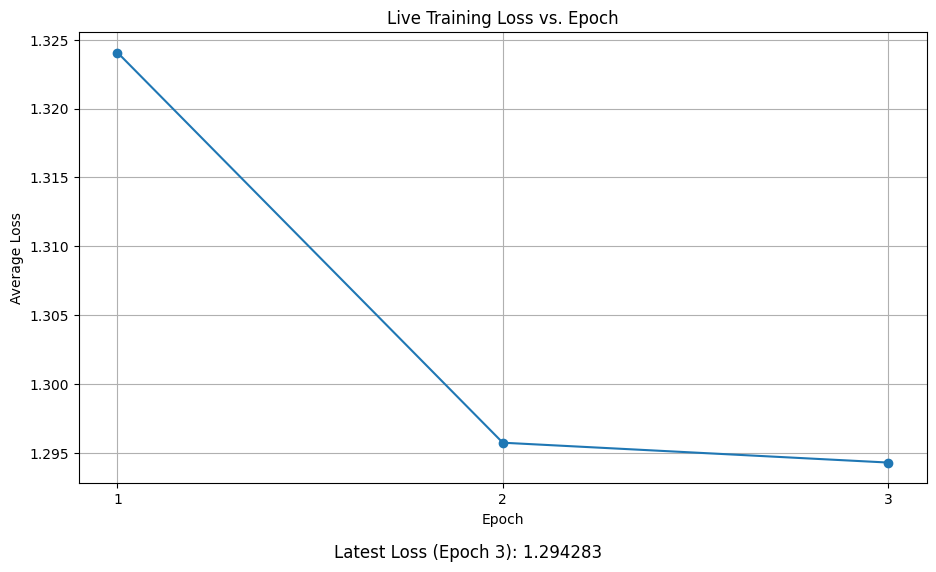

Epoch 4/100:  46%|████▌     | 6323/13830 [13:29<15:58,  7.83it/s, Loss=1.3848]

In [ ]:
loss_history = trainN.train_model(model, train_loader, CONFIG,device)

In [ ]:
import numpy as np

# 1. Get your target data (the log-normalized expression)
targets = adata.X.toarray() if hasattr(adata.X, "toarray") else np.asarray(adata.X)

# 2. Calculate the "dummy" prediction (just the average expression of each gene)
mean_expression = np.mean(targets, axis=0)

# 3. Calculate the MSE of this "dummy" model (this is the data variance)
baseline_mse = np.mean((targets - mean_expression)**2)

print(f"BASELINE MSE (Data Variance): {baseline_mse:.6f}")
print(f"Your model's loss (16.0) must drop BELOW this number to be useful.")